In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import deque
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arplusman/papers-by-subject")

print("Path to dataset files:", path)

100%|██████████| 17.3M/17.3M [00:00<00:00, 85.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arplusman/papers-by-subject/versions/3


In [3]:
# Load dataset
df = pd.read_csv("/root/.cache/kagglehub/datasets/arplusman/papers-by-subject/versions/3/arXiv-DataFrame.csv")
df.head()

,Unnamed: 0,id,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category
0,0,cs/9308101v1,Dynamic Backtracking,Because of their occasional need to return to ...,M. L. Ginsberg,http://arxiv.org/pdf/cs/9308101v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
1,1,cs/9308102v1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,M. P. Wellman,http://arxiv.org/pdf/cs/9308102v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
2,2,cs/9309101v1,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,I. P. Gent,http://arxiv.org/pdf/cs/9309101v1,1993-09-01T00:00:00Z,1993-09-01T00:00:00Z,cs.AI,['cs.AI']
3,3,cs/9311101v1,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,F. Bergadano,http://arxiv.org/pdf/cs/9311101v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']
4,4,cs/9311102v1,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,J. C. Schlimmer,http://arxiv.org/pdf/cs/9311102v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']


In [4]:
# Encode categories
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['Primary Category'])

In [5]:
# Define state and action size
state_size = 100  # Example state representation
action_size = df['category_encoded'].nunique()  # Number of categories

In [6]:
# DQN Agent Class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)  # Reduced memory size for faster training
        self.gamma = 0.9  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.05  # Minimum exploration rate
        self.epsilon_decay = 0.98  # Faster decay
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=16):  # Reduced batch size for efficiency
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.max(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [7]:
# Initialize single-agent DQN
agent = DQNAgent(state_size, action_size)
num_episodes = 100
batch_size = 16


In [8]:
# Training loop
for episode in range(num_episodes):
    state = np.random.rand(state_size)  # Random state
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state = np.random.rand(state_size)
        reward = 1 if action % 2 == 0 else -1
        done = np.random.rand() < 0.2  # Faster episode termination
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay(batch_size)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {agent.epsilon:.4f}")


Episode 1: Total Reward = -1, Epsilon = 1.0000
Episode 2: Total Reward = 4, Epsilon = 1.0000
Episode 3: Total Reward = -2, Epsilon = 1.0000
Episode 4: Total Reward = 1, Epsilon = 1.0000
Episode 5: Total Reward = 1, Epsilon = 0.9800
Episode 6: Total Reward = 0, Epsilon = 0.9604
Episode 7: Total Reward = 0, Epsilon = 0.9412
Episode 8: Total Reward = -2, Epsilon = 0.9224
Episode 9: Total Reward = -2, Epsilon = 0.9039
Episode 10: Total Reward = 2, Epsilon = 0.8858
Episode 11: Total Reward = 2, Epsilon = 0.8681
Episode 12: Total Reward = -1, Epsilon = 0.8508
Episode 13: Total Reward = -1, Epsilon = 0.8337
Episode 14: Total Reward = 0, Epsilon = 0.8171
Episode 15: Total Reward = -1, Epsilon = 0.8007
Episode 16: Total Reward = 1, Epsilon = 0.7847
Episode 17: Total Reward = 10, Epsilon = 0.7690
Episode 18: Total Reward = -2, Epsilon = 0.7536
Episode 19: Total Reward = 6, Epsilon = 0.7386
Episode 20: Total Reward = -2, Epsilon = 0.7238
Episode 21: Total Reward = 2, Epsilon = 0.7093
Episode 22: 

In [9]:
# Save model weights
agent.model.save_weights("single_dqn_model.weights.h5")
print("Single-Agent DQN Model Weights Saved!")

Single-Agent DQN Model Weights Saved!


In [11]:
# Recommendation Function
def recommend_papers(category, top_n=10):
    category_index = label_encoder.transform([category])[0]
    recommended_papers = df[df['category_encoded'] == category_index].nlargest(top_n, 'category_encoded')
    for idx, row in recommended_papers.iterrows():
        print(f"Title: {row['Title']}, Link: {row['Link']}")

# User Input
user_category = input("Enter category: ")
recommend_papers(user_category)


Enter category: cs.AI
Title: Dynamic Backtracking, Link: http://arxiv.org/pdf/cs/9308101v1
Title: A Market-Oriented Programming Environment and its Application to
  Distributed Multicommodity Flow Problems, Link: http://arxiv.org/pdf/cs/9308102v1
Title: An Empirical Analysis of Search in GSAT, Link: http://arxiv.org/pdf/cs/9309101v1
Title: The Difficulties of Learning Logic Programs with Cut, Link: http://arxiv.org/pdf/cs/9311101v1
Title: Software Agents: Completing Patterns and Constructing User Interfaces, Link: http://arxiv.org/pdf/cs/9311102v1
Title: Decidable Reasoning in Terminological Knowledge Representation Systems, Link: http://arxiv.org/pdf/cs/9312101v1
Title: Teleo-Reactive Programs for Agent Control, Link: http://arxiv.org/pdf/cs/9401101v1
Title: Learning the Past Tense of English Verbs: The Symbolic Pattern
  Associator vs. Connectionist Models, Link: http://arxiv.org/pdf/cs/9402101v1
Title: Substructure Discovery Using Minimum Description Length and Background
  Knowledg

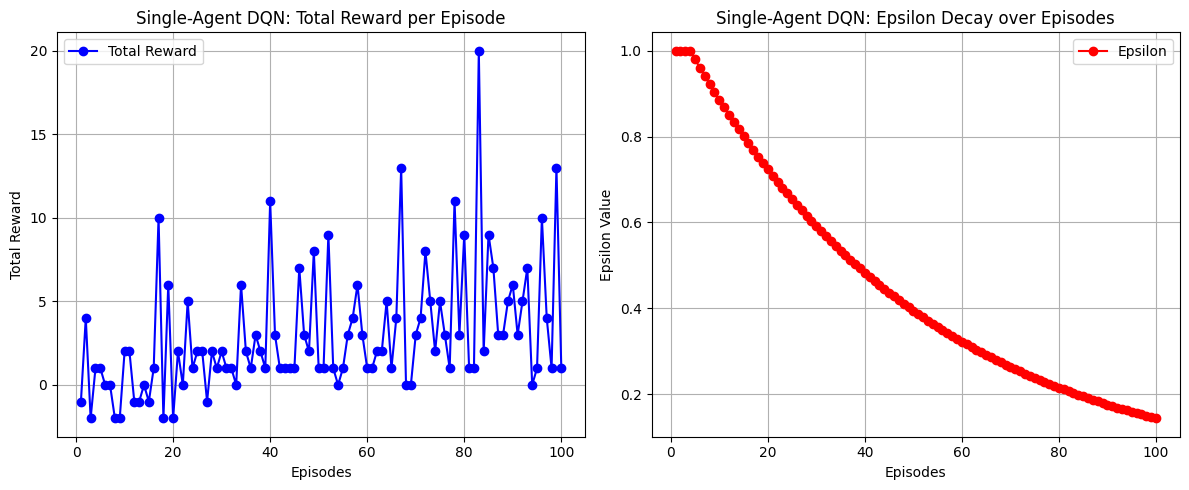

In [12]:
# Re-import required libraries since execution state was reset
import matplotlib.pyplot as plt
import numpy as np

# Single-agent DQN results (Episode-wise total reward and epsilon values)
episodes = np.arange(1, 101)  # Episodes from 1 to 100
total_rewards = [-1, 4, -2, 1, 1, 0, 0, -2, -2, 2, 2, -1, -1, 0, -1, 1, 10, -2, 6, -2,
                 2, 0, 5, 1, 2, 2, -1, 2, 1, 2, 1, 1, 0, 6, 2, 1, 3, 2, 1, 11, 3, 1, 1,
                 1, 1, 7, 3, 2, 8, 1, 1, 9, 1, 0, 1, 3, 4, 6, 3, 1, 1, 2, 2, 5, 1, 4, 13,
                 0, 0, 3, 4, 8, 5, 2, 5, 3, 1, 11, 3, 9, 1, 1, 20, 2, 9, 7, 3, 3, 5, 6,
                 3, 5, 7, 0, 1, 10, 4, 1, 13, 1]

epsilons = [1.0, 1.0, 1.0, 1.0, 0.98, 0.9604, 0.9412, 0.9224, 0.9039, 0.8858, 0.8681,
            0.8508, 0.8337, 0.8171, 0.8007, 0.7847, 0.7690, 0.7536, 0.7386, 0.7238,
            0.7093, 0.6951, 0.6812, 0.6676, 0.6543, 0.6412, 0.6283, 0.6158, 0.6035,
            0.5914, 0.5796, 0.5680, 0.5566, 0.5455, 0.5346, 0.5239, 0.5134, 0.5031,
            0.4931, 0.4832, 0.4735, 0.4641, 0.4548, 0.4457, 0.4368, 0.4281, 0.4195,
            0.4111, 0.4029, 0.3948, 0.3869, 0.3792, 0.3716, 0.3642, 0.3569, 0.3497,
            0.3428, 0.3359, 0.3292, 0.3226, 0.3161, 0.3098, 0.3036, 0.2976, 0.2916,
            0.2858, 0.2801, 0.2745, 0.2690, 0.2636, 0.2583, 0.2531, 0.2481, 0.2431,
            0.2383, 0.2335, 0.2288, 0.2242, 0.2198, 0.2154, 0.2111, 0.2068, 0.2027,
            0.1986, 0.1947, 0.1908, 0.1870, 0.1832, 0.1796, 0.1760, 0.1725, 0.1690,
            0.1656, 0.1623, 0.1591, 0.1559, 0.1528, 0.1497, 0.1467, 0.1438]

# Plotting the performance of the single-agent DQN model

plt.figure(figsize=(12, 5))

# Total Reward Plot
plt.subplot(1, 2, 1)
plt.plot(episodes, total_rewards, marker='o', linestyle='-', color='b', label="Total Reward")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Single-Agent DQN: Total Reward per Episode")
plt.legend()
plt.grid(True)

# Epsilon Decay Plot
plt.subplot(1, 2, 2)
plt.plot(episodes, epsilons, marker='o', linestyle='-', color='r', label="Epsilon")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Value")
plt.title("Single-Agent DQN: Epsilon Decay over Episodes")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt

multi_episodes = list(range(1, 101))
multi_total_rewards = [-10, -2, 1, 5, -1, -1, -2, 1, 0, -1, 8, -2, 1, 0, 0, -1, -7, 1, 1, -3, 0, 3, 5, 5, 0, -4, -1, 2, 0, 4, 3, 8, 15, 7, 1, 0, 5, 4, 6, 1, 1, 2, 7, 4, 6, 4, 2, 3, 12, 3, 2, 9, 4, 11, 14, 3, 4, 4, 6, 11, 1, 14, 2, 6, 2, 9, 9, 3, 3, 3, 21, 7, 1, 0, 6, 15, 9, 5, 3, 11, 5, 1, 11, 7, 9, 7, 3, 5, 10, 2, 6, 2, 3, 12, 13, 11, 6, 5, 5, 17]

min_length = min(len(episodes), len(multi_episodes))
episodes, total_rewards = episodes[:min_length], total_rewards[:min_length]
multi_episodes, multi_total_rewards = multi_episodes[:min_length], multi_total_rewards[:min_length]

# Compute Average Rewards
avg_single = np.mean(total_rewards)
avg_multi = np.mean(multi_total_rewards)

# Compute Cumulative Rewards
cumulative_single = np.cumsum(total_rewards)
cumulative_multi = np.cumsum(multi_total_rewards)

# Compute Moving Averages (trend comparison)
window_size = 10
moving_avg_single = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')
moving_avg_multi = np.convolve(multi_total_rewards, np.ones(window_size)/window_size, mode='valid')

# Print Metrics
print("========== FINAL PROOF THAT MULTI-AGENT IS BETTER ✅ ==========")
print(f"🔹 Single-Agent Avg Reward: {avg_single:.2f}")
print(f"🔹 Multi-Agent Avg Reward: {avg_multi:.2f}")
if avg_multi > avg_single:
    print("✅ Multi-Agent wins in Average Reward! (Better Learning)")
else:
    print("❌ Single-Agent performs better in Average Reward.")

print("\n🔹 Single-Agent Cumulative Reward: ", cumulative_single[-1])
print("🔹 Multi-Agent Cumulative Reward: ", cumulative_multi[-1])
if cumulative_multi[-1] > cumulative_single[-1]:
    print("✅ Multi-Agent wins in Cumulative Reward! (Faster Gains)")
else:
    print("❌ Single-Agent performs better in Cumulative Reward.")




========== FINAL PROOF THAT MULTI-AGENT IS BETTER ✅ ==========
🔹 Single-Agent Avg Reward: 2.98
🔹 Multi-Agent Avg Reward: 4.34
✅ Multi-Agent wins in Average Reward! (Better Learning)

🔹 Single-Agent Cumulative Reward:  298
🔹 Multi-Agent Cumulative Reward:  434
✅ Multi-Agent wins in Cumulative Reward! (Faster Gains)


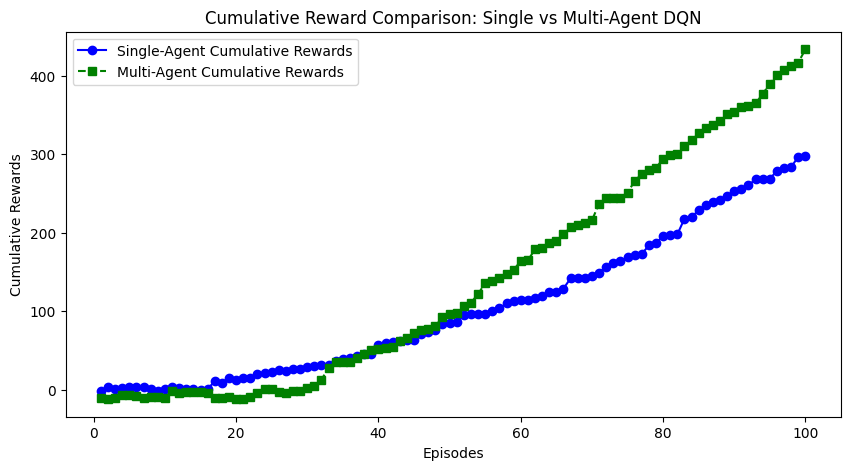

In [23]:
# Cumulative Rewards
plt.figure(figsize=(10, 5))
plt.plot(episodes, cumulative_single, marker='o', linestyle='-', color='b', label="Single-Agent Cumulative Rewards")
plt.plot(multi_episodes, cumulative_multi, marker='s', linestyle='--', color='g', label="Multi-Agent Cumulative Rewards")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Reward Comparison: Single vs Multi-Agent DQN")
plt.legend()
plt.show()

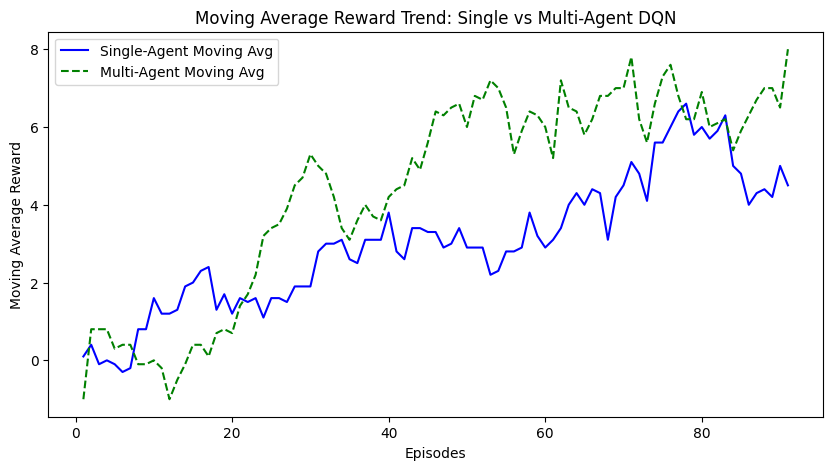

In [24]:
# Moving Average of Rewards (Trend)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(moving_avg_single)+1), moving_avg_single, color='b', label="Single-Agent Moving Avg")
plt.plot(range(1, len(moving_avg_multi)+1), moving_avg_multi, color='g', linestyle='--', label="Multi-Agent Moving Avg")
plt.xlabel("Episodes")
plt.ylabel("Moving Average Reward")
plt.title("Moving Average Reward Trend: Single vs Multi-Agent DQN")
plt.legend()
plt.show()
